# eICU Models

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import statsmodels.api as statm
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import umap
import random
import sqlite3
import time
import os
print(os.getcwd())

# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 20 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

/Users/mengphilshen/Dropbox/Warehouse/eICU


## Data Source
The eICU Collaborative Research Database, a multi-center intensive care unit (ICU)database with high granularity data for over 200,000 admissions to ICUs monitored by eICU Programs across the United States.

## Patient Selection

* Patient ICU Stays identified through Sepsis diagnosis
* Patient without missing ICU Discharge Status 
* Patient admission from 2014 through 2015
* Patient 18 years and older
* Patient with valid demographic information
* Patient with APACHE score

## Mortality Risk Model

### Preprocess Data

In [2]:
# Load intermediate datasets
sep_patient3 = pd.read_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/sep_patient3.csv')
sep_apache3 = pd.read_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/sep_apache3.csv')

In [3]:
# Select patient variables
patient_var0 = sep_patient3[['patientunitstayid', 'age_group', 'ethnicity2', 'gender']]
patient_var1 = pd.get_dummies(patient_var0)
patient_var1 = patient_var1.drop(['gender_Male', 'age_group_18-35', 'ethnicity2_African American'], axis = 1)
patient_var1.head()

,patientunitstayid,age_group_36-65,age_group_66-89,age_group_89+,ethnicity2_Asian,ethnicity2_Caucasian,ethnicity2_Hispanic,ethnicity2_Native American,ethnicity2_Other/Unknown,gender_Female
0,141227,0,1,0,0,1,0,0,0,0
1,141288,1,0,0,0,1,0,0,0,1
2,141304,0,1,0,0,1,0,0,0,0
3,141392,0,1,0,0,1,0,0,0,1
4,141462,0,1,0,0,1,0,0,0,0


In [4]:
# Select apache variables
apache_var0 = sep_apache3.drop(['actualiculos'], axis = 1)
def func(x):
    if x == "EXPIRED":
        return 1
    else:
        return 0
apache_var0['icumortality'] = apache_var0['actualicumortality'].apply(func)
apache_var1 = apache_var0.drop(['actualicumortality', 'acutephysiologyscore'], axis = 1)
apache_var1.head()

,patientunitstayid,apachescore,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,...,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,ima,midur,diabetes,icumortality
0,141227,100,-1.0,42.7,40.1,54.0,133.0,204,198,7.46,...,0,0,0,0,0,0,0,0,0,0
1,141288,33,-1.0,16.3,36.6,46.0,140.0,105,64,7.37,...,0,0,0,0,0,0,0,0,0,0
2,141304,67,-1.0,12.8,36.6,28.0,140.0,120,60,-1.00,...,0,0,0,0,1,0,0,0,0,0
3,141392,35,-1.0,17.5,36.6,22.0,137.0,82,118,-1.00,...,0,0,0,0,0,0,0,0,1,0
4,141462,53,-1.0,14.5,36.6,55.0,132.0,102,64,-1.00,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# Merge dataset
merged_data = pd.merge(patient_var1, apache_var1, on = 'patientunitstayid')
merged_data.set_index(['patientunitstayid'], inplace = True) 
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17545 entries, 141227 to 3353251
Data columns (total 46 columns):
age_group_36-65               17545 non-null uint8
age_group_66-89               17545 non-null uint8
age_group_89+                 17545 non-null uint8
ethnicity2_Asian              17545 non-null uint8
ethnicity2_Caucasian          17545 non-null uint8
ethnicity2_Hispanic           17545 non-null uint8
ethnicity2_Native American    17545 non-null uint8
ethnicity2_Other/Unknown      17545 non-null uint8
gender_Female                 17545 non-null uint8
apachescore                   17545 non-null int64
urine                         17545 non-null float64
wbc                           17545 non-null float64
temperature                   17545 non-null float64
respiratoryrate               17545 non-null float64
sodium                        17545 non-null float64
heartrate                     17545 non-null int64
meanbp                        17545 non-null int64
ph     

In [93]:
# Save merged_data
merged_data.to_csv('/Users/mengphilshen/Dropbox/Warehouse/eICU/intermediate_data/merged_data.csv')

In [6]:
# Seperate class
Y = merged_data.iloc[:, merged_data.columns == 'icumortality']
Y['icumortality'].value_counts()

0    15565
1     1980
Name: icumortality, dtype: int64

In [7]:
# Seperate features
X = merged_data.iloc[:, merged_data.columns != 'icumortality']
X.describe() 

,age_group_36-65,age_group_66-89,age_group_89+,ethnicity2_Asian,ethnicity2_Caucasian,ethnicity2_Hispanic,ethnicity2_Native American,ethnicity2_Other/Unknown,gender_Female,apachescore,...,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,ima,midur,diabetes
count,17545.000000,17545.000000,17545.00000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.00000,17545.000000,...,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000,17545.000000
mean,0.403363,0.487831,0.04896,0.016586,0.776803,0.047250,0.008492,0.053121,0.48538,68.487717,...,0.002622,0.019094,0.008093,0.029752,0.014192,0.052038,0.025021,0.001368,0.005529,0.241550
std,0.490586,0.499866,0.21579,0.127717,0.416402,0.212179,0.091765,0.224280,0.49980,27.772305,...,0.051138,0.136859,0.089601,0.169907,0.118286,0.222109,0.156194,0.036961,0.074151,0.428035
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,84.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,211.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


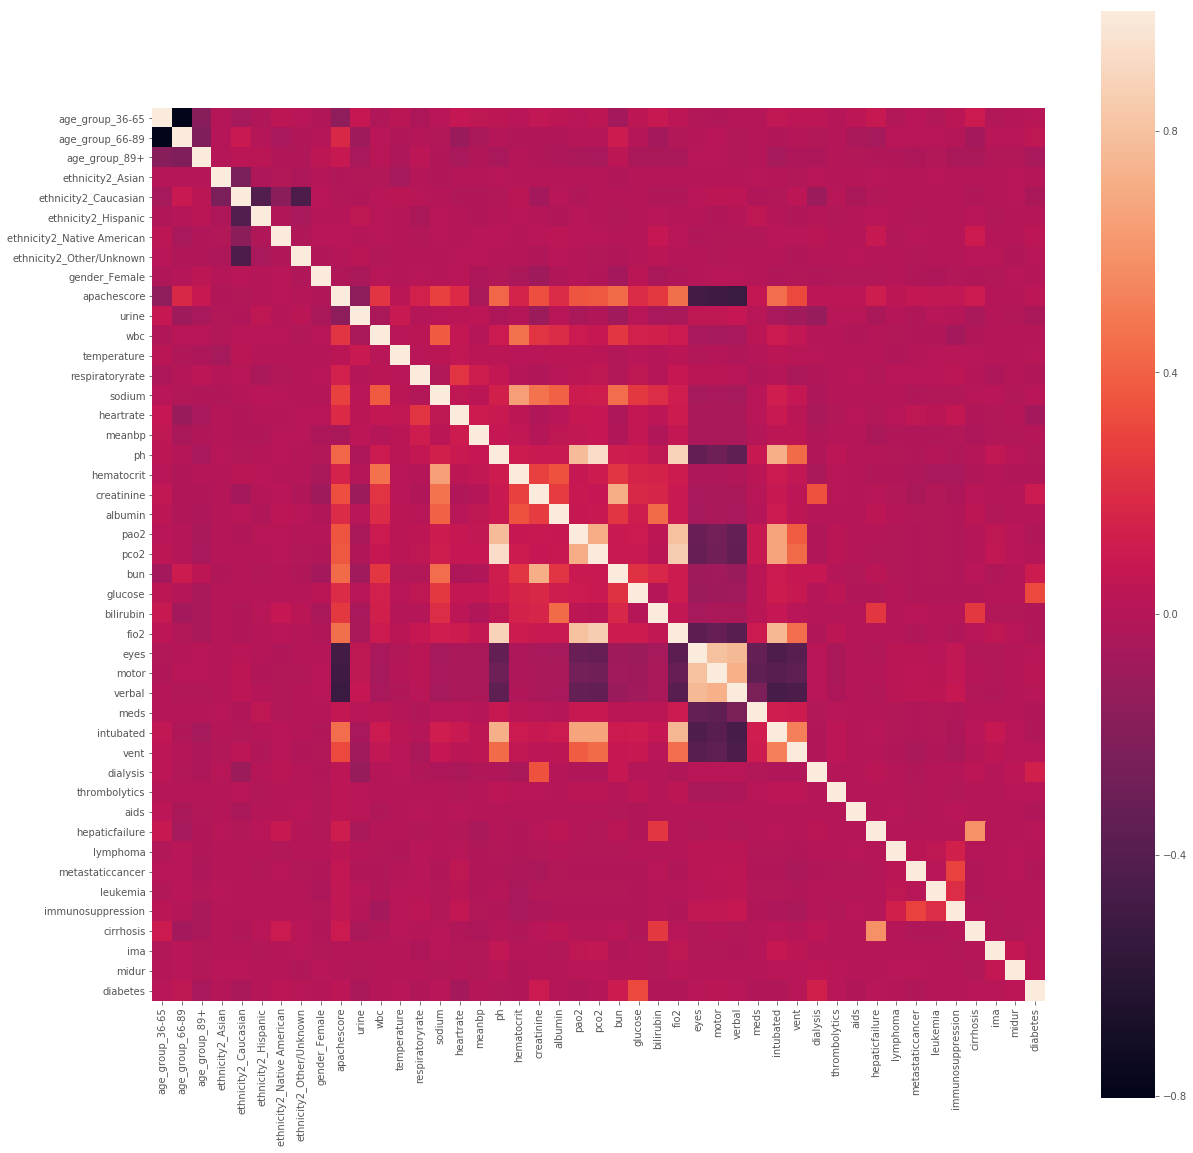

In [8]:
# Check correlations
corrmat = X.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, square = True)
plt.show()

### Split training and test set

In [9]:
# Split into the training set and test set
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.30, random_state = 42)
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_Y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_Y.shape)

Training Features Shape: (12281, 45)
Training Labels Shape: (12281, 1)
Testing Features Shape: (5264, 45)
Testing Labels Shape: (5264, 1)


In [10]:
train_Y['icumortality'].value_counts()

0    10907
1     1374
Name: icumortality, dtype: int64

In [11]:
test_Y['icumortality'].value_counts()

0    4658
1     606
Name: icumortality, dtype: int64

In [12]:
# Clean test sets to avoid future warning messages
train_Y = train_Y.values.ravel() 
test_Y = test_Y.values.ravel() 

In [13]:
# Scale features
scale = StandardScaler()
train_Xs = scale.fit_transform(train_X)
test_Xs = scale.fit_transform(test_X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [82]:
# Scale features
scale = StandardScaler()
Xs = scale.fit_transform(X)
Ys = Y.values.ravel() 

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [83]:
# Specify graph setting
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 42

In [84]:
# Utility function to visualize the outputs of t-SNE
def sepsis_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [85]:
from sklearn.manifold import TSNE
sepsis_tsne = TSNE(random_state=RS).fit_transform(X)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.1734875, 0.15838322, '0'), Text(-5.724559, -8.197144, '1')])

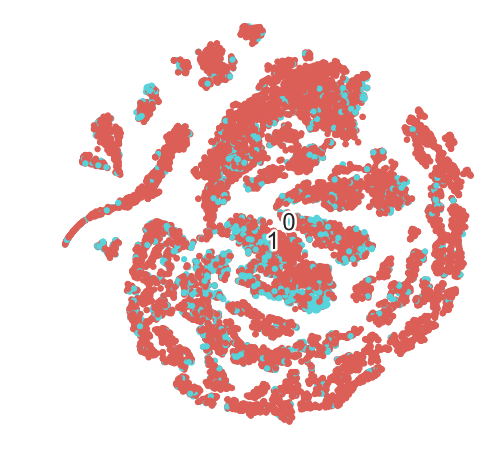

In [72]:
sepsis_scatter(sepsis_tsne, Ys)

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.18271169, -55.101913, '0'),
  Text(-5.047338, 18.405437, '1'),
  Text(-52.899178, 21.757988, '2'),
  Text(66.71685, -2.206974, '3'),
  Text(-89.55025, -2.596159, '4')])

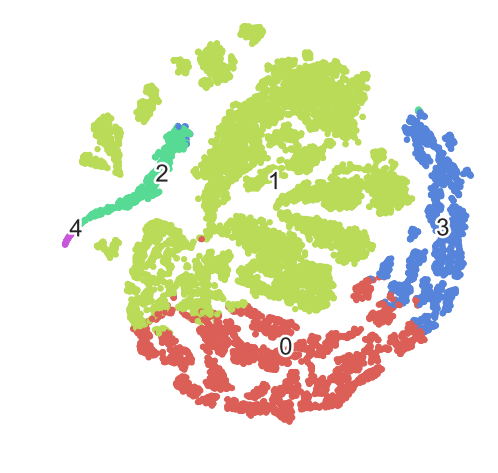

In [76]:
sepsis_scatter(sepsis_tsne, Y_kmeans)

### K-means Clustering

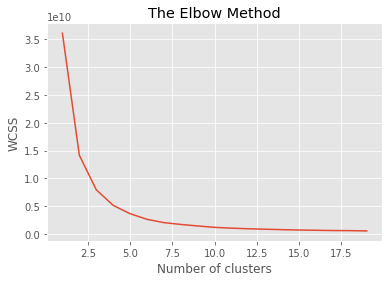

In [57]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [74]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.18271169, -55.101913, '0'),
  Text(-5.047338, 18.405437, '1'),
  Text(-52.899178, 21.757988, '2'),
  Text(66.71685, -2.206974, '3'),
  Text(-89.55025, -2.596159, '4')])

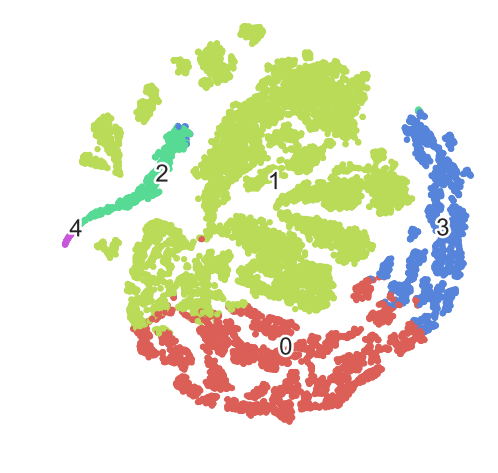

In [75]:
sepsis_scatter(sepsis_tsne, Y_kmeans)

In [88]:
# Add cluster indicators into X
merged_data_new = merged_data.assign(Cluster=Y_kmeans)
merged_data_new.head()

,age_group_36-65,age_group_66-89,age_group_89+,ethnicity2_Asian,ethnicity2_Caucasian,ethnicity2_Hispanic,ethnicity2_Native American,ethnicity2_Other/Unknown,gender_Female,apachescore,...,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,ima,midur,diabetes,icumortality,Cluster
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141227,0,1,0,0,1,0,0,0,0,100,...,0,0,0,0,0,0,0,0,0,1
141288,1,0,0,0,1,0,0,0,1,33,...,0,0,0,0,0,0,0,0,0,1
141304,0,1,0,0,1,0,0,0,0,67,...,0,0,0,1,0,0,0,0,0,1
141392,0,1,0,0,1,0,0,0,1,35,...,0,0,0,0,0,0,0,1,0,1
141462,0,1,0,0,1,0,0,0,0,53,...,0,0,0,0,0,0,0,1,0,1


In [100]:
sub_sample1 = merged_data_new[merged_data_new.Cluster != 4]
sub_sample2 = sub_sample1[sub_sample1.Cluster != 2]
sub_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16731 entries, 141227 to 3353251
Data columns (total 47 columns):
age_group_36-65               16731 non-null uint8
age_group_66-89               16731 non-null uint8
age_group_89+                 16731 non-null uint8
ethnicity2_Asian              16731 non-null uint8
ethnicity2_Caucasian          16731 non-null uint8
ethnicity2_Hispanic           16731 non-null uint8
ethnicity2_Native American    16731 non-null uint8
ethnicity2_Other/Unknown      16731 non-null uint8
gender_Female                 16731 non-null uint8
apachescore                   16731 non-null int64
urine                         16731 non-null float64
wbc                           16731 non-null float64
temperature                   16731 non-null float64
respiratoryrate               16731 non-null float64
sodium                        16731 non-null float64
heartrate                     16731 non-null int64
meanbp                        16731 non-null int64
ph     

In [102]:
sub_Y = sub_sample2.iloc[:, sub_sample2.columns == 'icumortality']
sub_X = sub_sample2.iloc[:, sub_sample2.columns != 'icumortality']

In [103]:
# Split into the training set and test set
sub_train_X, sub_test_X, sub_train_Y, sub_test_Y = train_test_split(sub_X, sub_Y, test_size = 0.30, random_state = 42)
print('Training Features Shape:', sub_train_X.shape)
print('Training Labels Shape:', sub_train_Y.shape)
print('Testing Features Shape:', sub_test_X.shape)
print('Testing Labels Shape:', sub_test_Y.shape)

Training Features Shape: (11711, 46)
Training Labels Shape: (11711, 1)
Testing Features Shape: (5020, 46)
Testing Labels Shape: (5020, 1)


In [105]:
# Clean test sets to avoid future warning messages
sub_train_Y = sub_train_Y.values.ravel() 
sub_test_Y = sub_test_Y.values.ravel() 

### Synthetic Minortiy Over-sampling Technique (SMOTE)

In [14]:
# Upsampling with SMOTE
sm = SMOTE(random_state = 42)
train_X_res, train_Y_res = sm.fit_sample(train_X, train_Y)

In [15]:
# Check before and after sampling
print('Before OverSampling, the shape of train_X: {}'.format(train_X.shape))
print('Before OverSampling, the shape of train_Y: {} \n'.format(train_Y.shape))
print("Before OverSampling, counts of label '1': {}".format(sum(train_Y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_Y==0)))

print('After OverSampling, the shape of train_X_res: {}'.format(train_X_res.shape))
print('After OverSampling, the shape of train_Y_res: {} \n'.format(train_Y_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(train_Y_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(train_Y_res==0)))

Before OverSampling, the shape of train_X: (12281, 45)
Before OverSampling, the shape of train_Y: (12281,) 

Before OverSampling, counts of label '1': 1374
Before OverSampling, counts of label '0': 10907 

After OverSampling, the shape of train_X_res: (21814, 45)
After OverSampling, the shape of train_Y_res: (21814,) 

After OverSampling, counts of label '1': 10907
After OverSampling, counts of label '0': 10907 



### Define functions

In [16]:
# Define the variable_importance function
def variable_importance(fit):
    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [17]:
# Define the print_var_importance function
def print_var_importance(importance, indices, name_index):

    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [18]:
# Define the variable_importance_plot function
def variable_importance_plot(importance, indices, name_index):

    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(20, 20))

    plt.title('Feature importances for Random Forest Model')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)
    
    plt.ylim(-1, 50)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

In [19]:
# define the create_conf_mat function
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

In [104]:
# Define the print_class_report function
def print_class_report(predictions, alg_name):
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(test_Y, predictions))

In [20]:
# Define the plot_roc_curve function
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
 
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
        \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()    

### Random Forests - Train models adjusting for class weight

In [51]:
# Create hyperparameter search space
param_grid_rf = {
    'min_samples_split': [5, 10], 
    'max_depth': [5, 15, 25],
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [52]:
# Instantiate model with 1000 decision trees
fit_rf = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced', random_state = 42)

In [53]:
# Create grid search
def grid_search_wrapper_rf(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(fit_rf, param_grid_rf, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_X, train_Y)

    # make the predictions
    y_pred = grid_search.predict(test_X)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_Y, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [54]:
# Conduct grid search
grid_search_rf = grid_search_wrapper_rf(refit_score='recall_score')

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

Best params for recall_score
{'max_depth': 5, 'min_samples_split': 10}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      3717       941
pos       188       418


In [55]:
# Fit model
fit_rf_best = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_split = 10, class_weight = 'balanced', random_state = 42)

In [56]:
# Train the model on training data
fit_rf_best.fit(train_X, train_Y);

In [57]:
# Run the print_var_importance function
var_imp_rf = variable_importance(fit_rf_best)
importances_rf = var_imp_rf['importance']
indices_rf = var_imp_rf['index']
names_index = list(X.columns.values)
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'apachescore' has a Mean Decrease in Impurity of 0.27107
2. The feature 'fio2' has a Mean Decrease in Impurity of 0.08119
3. The feature 'meanbp' has a Mean Decrease in Impurity of 0.05493
4. The feature 'ph' has a Mean Decrease in Impurity of 0.05441
5. The feature 'verbal' has a Mean Decrease in Impurity of 0.04803
6. The feature 'vent' has a Mean Decrease in Impurity of 0.04373
7. The feature 'pao2' has a Mean Decrease in Impurity of 0.04193
8. The feature 'motor' has a Mean Decrease in Impurity of 0.04120
9. The feature 'eyes' has a Mean Decrease in Impurity of 0.03983
10. The feature 'temperature' has a Mean Decrease in Impurity of 0.03875
11. The feature 'urine' has a Mean Decrease in Impurity of 0.03621
12. The feature 'pco2' has a Mean Decrease in Impurity of 0.03620
13. The feature 'creatinine' has a Mean Decrease in Impurity of 0.03340
14. The feature 'intubated' has a Mean Decrease in Impurity of 0.02931
15. The feature 'bun' has a Mean Decrea

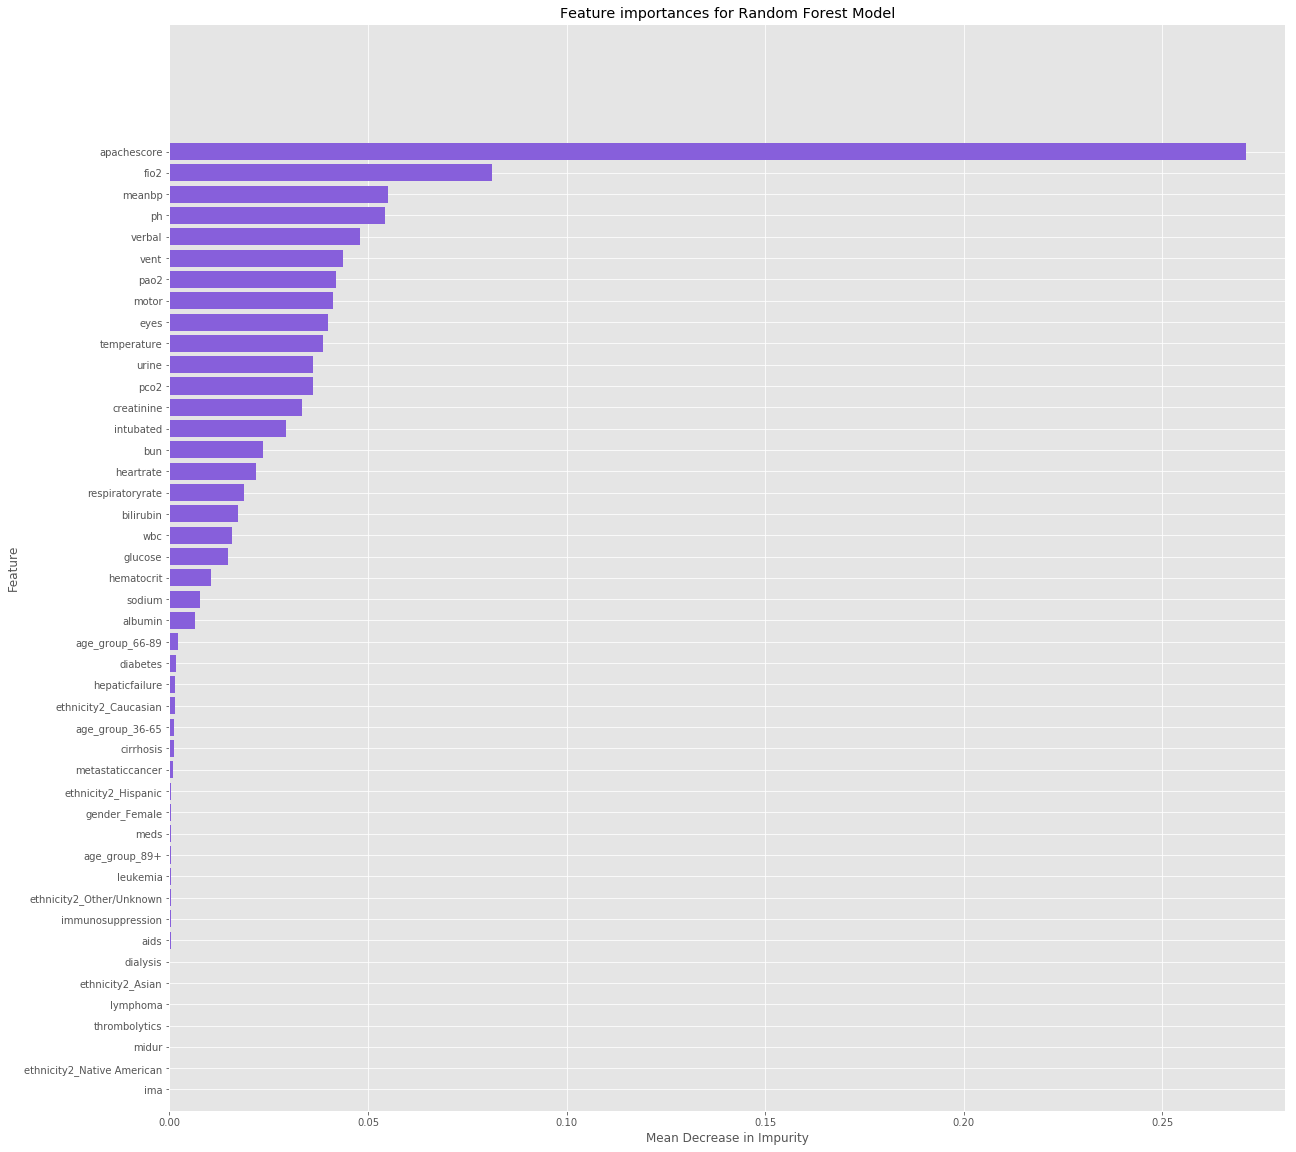

In [58]:
# Run the variable_importance_plot function
variable_importance_plot(importances_rf, indices_rf, names_index)

In [59]:
# predict the test data
predictions_rf = fit_rf_best.predict(test_X)

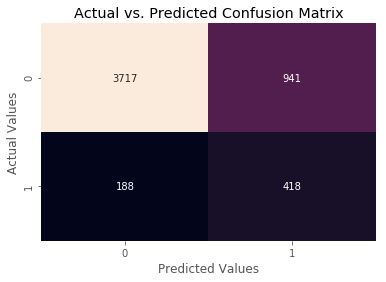

In [60]:
# Run the create_conf_mat function
conf_mat_rf = create_conf_mat(test_Y, predictions_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [61]:
print(classification_report(test_Y, predictions_rf))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4658
           1       0.31      0.69      0.43       606

   micro avg       0.79      0.79      0.79      5264
   macro avg       0.63      0.74      0.65      5264
weighted avg       0.88      0.79      0.82      5264



In [63]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_rf = fit_rf_best.predict_proba(test_X)[:, 1]
fpr2_rf, tpr2_rf, _ = roc_curve(test_Y, predictions_prob_rf, pos_label = 1)
auc_rf = auc(fpr2_rf, tpr2_rf)

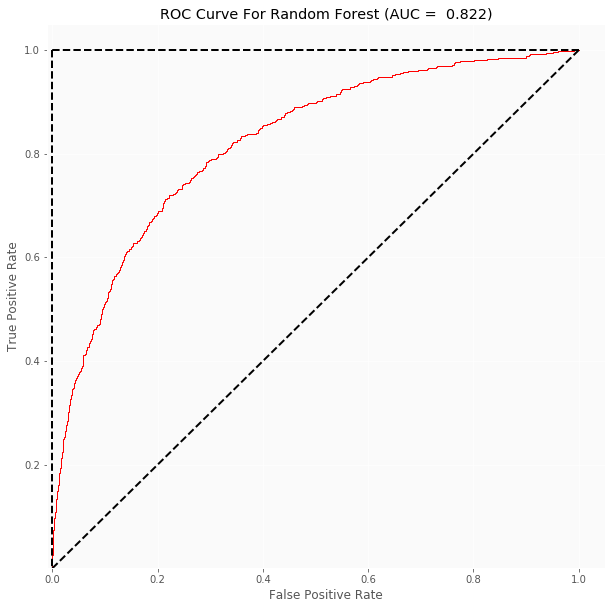

In [64]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_rf, tpr2_rf, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Random Forest - Train model after Upsampling

In [68]:
# Instantiate model with 1000 decision trees
fit_rf_res = RandomForestClassifier(n_estimators = 1000, class_weight = 'balanced', random_state = 42)

In [69]:
# Create grid search
def grid_search_wrapper_rf_res(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(fit_rf_res, param_grid_rf, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_X_res, train_Y_res)

    # make the predictions
    y_pred = grid_search.predict(test_X)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_Y, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [70]:
# Conduct grid search
grid_search_rf_res = grid_search_wrapper_rf_res(refit_score='recall_score')

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

Best params for recall_score
{'max_depth': 25, 'min_samples_split': 5}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      4567        91
pos       473       133


In [71]:
# Fit model
fit_rf_res_best = RandomForestClassifier(n_estimators = 1000, max_depth = 25, min_samples_split = 5, class_weight = 'balanced', random_state = 42)

In [72]:
# Train the model on training data
fit_rf_res_best.fit(train_X_res, train_Y_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

In [73]:
# Run the print_var_importance function
var_imp_rf_res = variable_importance(fit_rf_res_best)
importances_rf_res = var_imp_rf_res['importance']
indices_rf_res = var_imp_rf_res['index']
names_index = list(X.columns.values)
print_var_importance(importances_rf_res, indices_rf_res, names_index)

Feature ranking:
1. The feature 'vent' has a Mean Decrease in Impurity of 0.10250
2. The feature 'apachescore' has a Mean Decrease in Impurity of 0.08238
3. The feature 'verbal' has a Mean Decrease in Impurity of 0.07119
4. The feature 'motor' has a Mean Decrease in Impurity of 0.06414
5. The feature 'eyes' has a Mean Decrease in Impurity of 0.05855
6. The feature 'age_group_66-89' has a Mean Decrease in Impurity of 0.05711
7. The feature 'age_group_36-65' has a Mean Decrease in Impurity of 0.04362
8. The feature 'gender_Female' has a Mean Decrease in Impurity of 0.03932
9. The feature 'albumin' has a Mean Decrease in Impurity of 0.03196
10. The feature 'diabetes' has a Mean Decrease in Impurity of 0.03142
11. The feature 'bilirubin' has a Mean Decrease in Impurity of 0.02944
12. The feature 'ethnicity2_Caucasian' has a Mean Decrease in Impurity of 0.02429
13. The feature 'temperature' has a Mean Decrease in Impurity of 0.02409
14. The feature 'meanbp' has a Mean Decrease in Impurity o

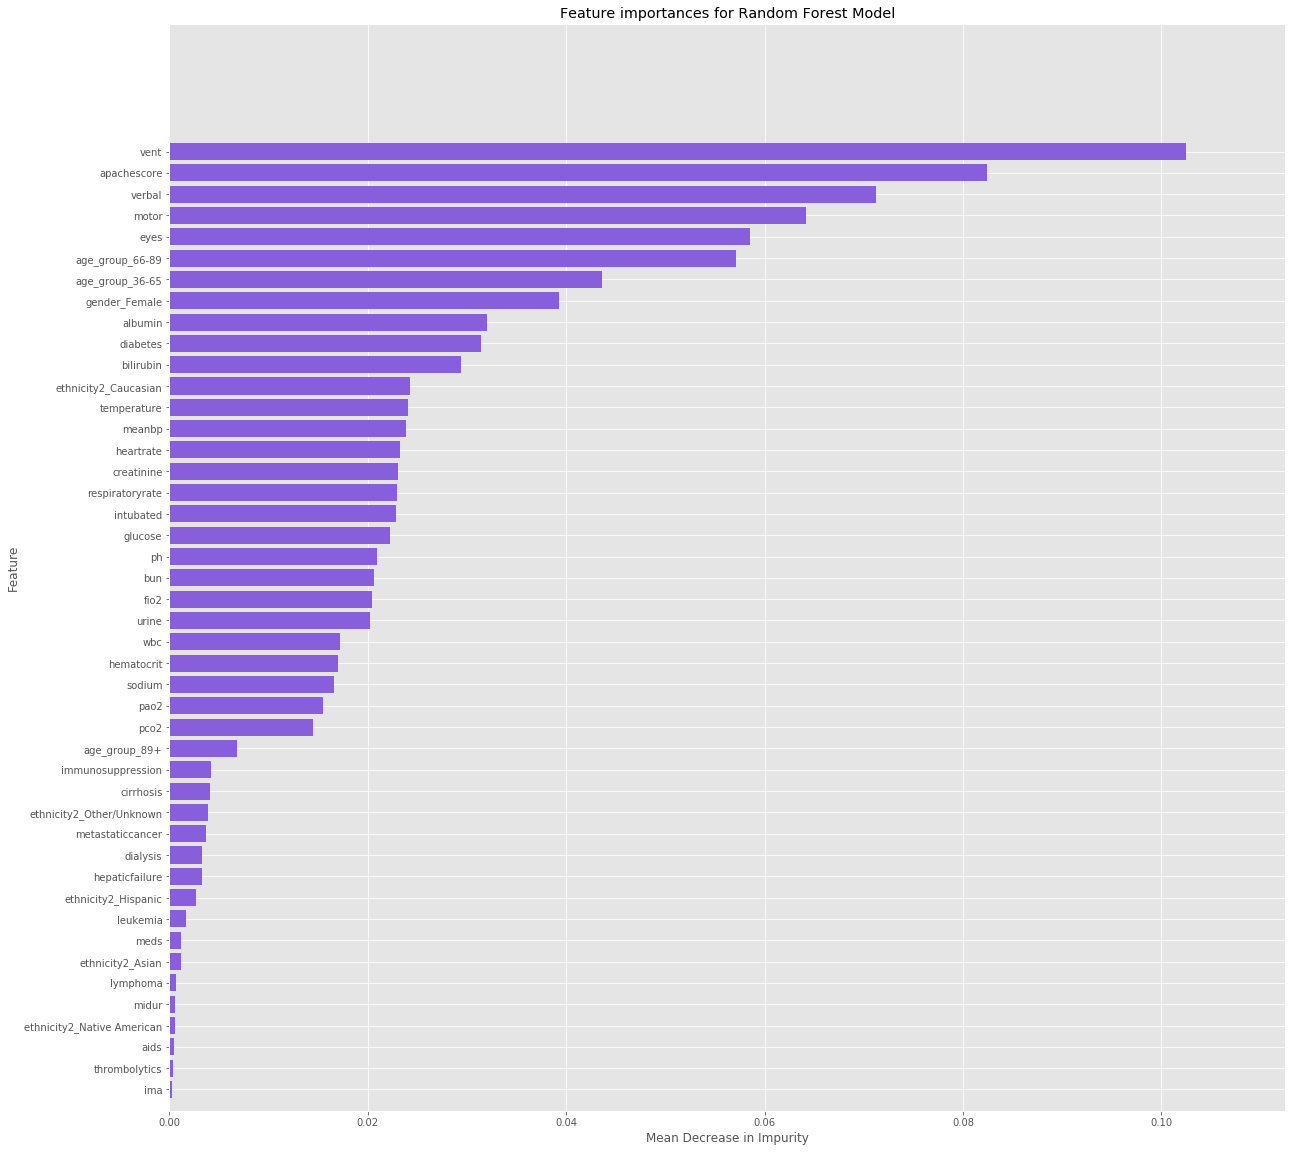

In [74]:
# Run the variable_importance_plot function
variable_importance_plot(importances_rf_res, indices_rf_res, names_index)

In [76]:
# predict the test data
predictions_rf_res = fit_rf_res_best.predict(test_X)

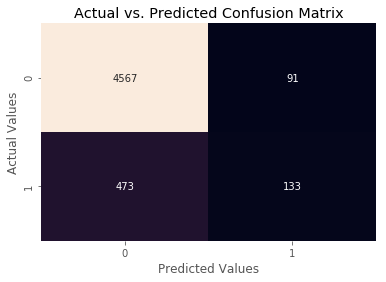

In [77]:
# Run the create_conf_mat function
conf_mat_rf_res = create_conf_mat(test_Y, predictions_rf_res)
sns.heatmap(conf_mat_rf_res, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [78]:
print(classification_report(test_Y, predictions_rf_res))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4658
           1       0.59      0.22      0.32       606

   micro avg       0.89      0.89      0.89      5264
   macro avg       0.75      0.60      0.63      5264
weighted avg       0.87      0.89      0.87      5264



In [80]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_rf_res = fit_rf_res_best.predict_proba(test_X)[:, 1]
fpr2_rf_res, tpr2_rf_res, _ = roc_curve(test_Y, predictions_prob_rf_res, pos_label = 1)
auc_rf_res = auc(fpr2_rf_res, tpr2_rf_res)

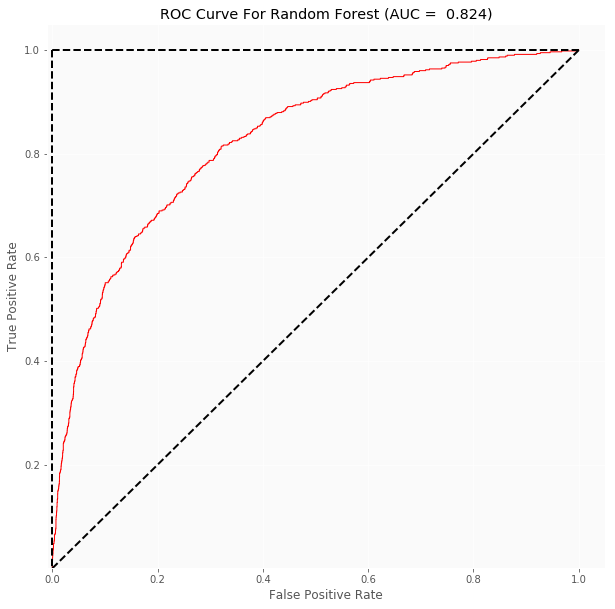

In [81]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_rf_res, tpr2_rf_res, auc_rf_res, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Logistic Regression - Statistical Inference

In [12]:
## Fit logistic regression
X_const = statm.add_constant(X)
logit_model = statm.Logit(Y, X_const)
logit_result = logit_model.fit()
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.278084
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           icumortality   No. Observations:                17545
Model:                          Logit   Df Residuals:                    17499
Method:                           MLE   Df Model:                           45
Date:                Tue, 29 Jan 2019   Pseudo R-squ.:                  0.2110
Time:                        10:25:13   Log-Likelihood:                -4879.0
converged:                       True   LL-Null:                       -6183.5
                                        LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.9484      0.309    -16.039      0.000      

### Logistic Regression  - Train models adjusting for class weight

In [23]:
# Create hyperparameter search space
param_grid = {
    'C': np.logspace(-5,5,11),
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [24]:
# Instantiate model
fit_log = LogisticRegression(penalty = 'l1', solver='saga', tol=0.01, class_weight = 'balanced', random_state = 42)

In [25]:
# Create grid search
def grid_search_wrapper_log(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(fit_log, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_X, train_Y)

    # make the predictions
    y_pred = grid_search.predict(test_X)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_Y, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [26]:
# Conduct grid search
grid_search_log = grid_search_wrapper_log(refit_score='precision_score')

Best params for precision_score
{'C': 0.1}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      3312      1346
pos       166       440


In [27]:
# Fit model
fit_log_best = LogisticRegression(penalty = 'l1', solver='saga', C=0.1, class_weight = 'balanced', random_state = 42)

In [28]:
# Train the model on training data
fit_log_best.fit(train_X, train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [29]:
# predict the test data
predictions_log = fit_log_best.predict(test_X)

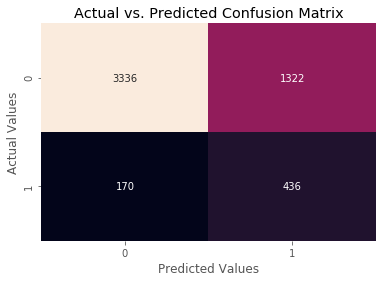

In [30]:
# Run the create_conf_mat function
conf_mat_log = create_conf_mat(test_Y, predictions_log)
sns.heatmap(conf_mat_log, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [31]:
print(classification_report(test_Y, predictions_log))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4658
           1       0.25      0.72      0.37       606

   micro avg       0.72      0.72      0.72      5264
   macro avg       0.60      0.72      0.59      5264
weighted avg       0.87      0.72      0.77      5264



In [32]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob_log = fit_log_best.predict_proba(test_X)[:, 1]
fpr2_log, tpr2_log, _ = roc_curve(test_Y, predictions_prob_log, pos_label = 1)
auc_rf_log = auc(fpr2_log, tpr2_log)

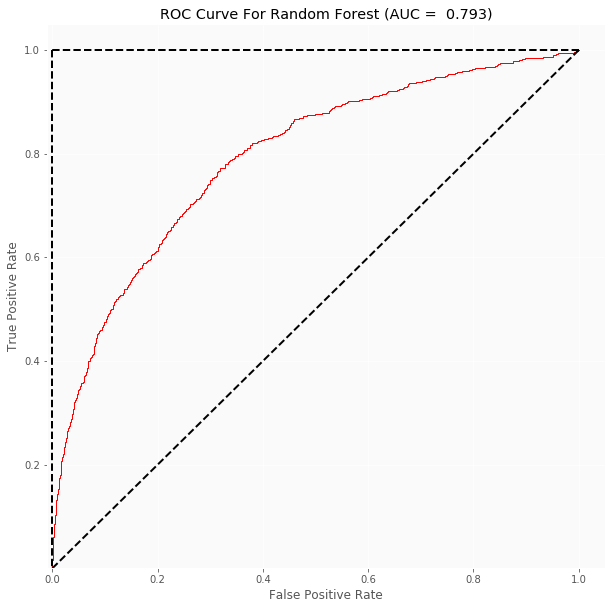

In [33]:
# Run the plot_roc_curve function
plot_roc_curve(fpr2_log, tpr2_log, auc_rf_log, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

### Logistic Regression - Train model after Upsampling

In [36]:
# Instantiate model
fit_log_res = LogisticRegression(penalty = 'l1', solver='saga', tol=0.01, class_weight = 'balanced', random_state = 42)

In [37]:
# Create grid search
def grid_search_wrapper_log_res(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(fit_log_res, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_X_res, train_Y_res)

    # make the predictions
    y_pred = grid_search.predict(test_X)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_Y, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [38]:
# Conduct grid search
grid_search_log_res = grid_search_wrapper_log_res(refit_score='precision_score')

Best params for precision_score
{'C': 0.1}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      3328      1330
pos       167       439


In [39]:
# Fit model
fit_log_res_best = LogisticRegression(penalty = 'l1', solver='saga', C=0.1, class_weight = 'balanced', random_state = 42)

In [44]:
# Train the model on training data
fit_log_res_best.fit(train_X_res, train_Y_res);

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [48]:
# predict the test data
predictions_log_res = fit_log_res_best.predict(test_X)

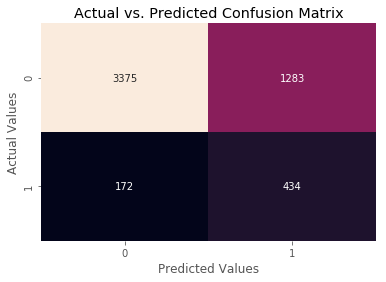

In [46]:
# Run the create_conf_mat function
conf_mat_log_res = create_conf_mat(test_Y, predictions_log_res)
sns.heatmap(conf_mat_log_res, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [49]:
print(classification_report(test_Y, predictions_log_res))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4658
           1       0.25      0.72      0.37       606

   micro avg       0.72      0.72      0.72      5264
   macro avg       0.60      0.72      0.60      5264
weighted avg       0.87      0.72      0.77      5264



### Subsample Analysis

In [106]:
# Instantiate model
fit_log_sub = LogisticRegression(class_weight = 'balanced', random_state = 42)

In [107]:
# Train the model on training data
fit_log_sub.fit(sub_train_X, sub_train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [108]:
# predict the test data
predictions_log_sub = fit_log_sub.predict(sub_test_X)

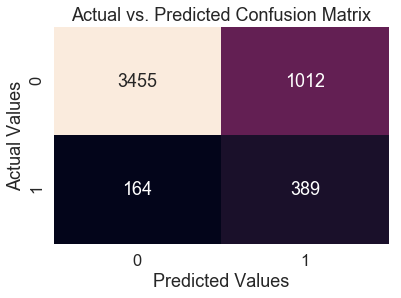

In [109]:
# Run the create_conf_mat function
conf_mat_log = create_conf_mat(sub_test_Y, predictions_log_sub)
sns.heatmap(conf_mat_log, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [112]:
# Define the print_class_report function
def print_class_report_sub(predictions, alg_name):
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(sub_test_Y, predictions))
    
# Run the print_class_report function    
class_report_log_sub = print_class_report_sub(predictions_log_sub, 'Logistic Regression')

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4467
           1       0.28      0.70      0.40       553

   micro avg       0.77      0.77      0.77      5020
   macro avg       0.62      0.74      0.63      5020
weighted avg       0.88      0.77      0.80      5020

